In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import MyNN

In [2]:
class PGAgent:
    def __init__(self, state_size, action_size, gamma=0.95,learning_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # discount rate
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        model = MyNN.MyNN(self.state_size)
        model.add(24, 'ReLU')
        model.add(24, 'ReLU')
        model.add(1, 'Sigmoid')
        model.compile('Cross entropy', 'Adam')
        return model

    def act(self, state):
        result = self.model.forward(state)[0][0]
        return 1 if result > np.random.random() else 0

In [129]:
def play_game(agent, render=False):
    state = env.reset()
    memory = np.array([0,0,0,0]).reshape(4,1)
    actions = np.array([])
    rewards = np.array([])
    for time in range(500):
        if render:
            env.render()
        memory = np.hstack((memory, state.reshape(4,1)))
        action = agent.act(state)
        actions = np.append(actions, action)
        state, reward, done, _ = env.step(action)
        state = state.reshape(4,1)
        if done:
            reward = -10
        if time == 498:
            reward = 20
        rewards = np.append(rewards, reward)
        if done or time == 498:
            break
    return memory[:,1:], actions.reshape(1,-1), rewards.reshape(1,-1), time

In [130]:
def running_reward(rewards, gamma):
    result = []
    run_rew = 0
    for reward in  rewards[0,:][::-1]:
        run_rew = run_rew*gamma + reward
        result.append(run_rew)
    return np.hstack(result[::-1]).reshape(1,-1)

In [131]:
def play_n_games(agent, n=20):
    X_batch = np.array([0,0,0,0]).reshape(4,1)
    y_batch = np.array([[0]])
    weights = np.array([[0]])
    results = []
    for i in range(n):
        a, b, c, d = play_game(agent)
        X_batch = np.hstack((X_batch, a))
        y_batch = np.hstack((y_batch, b))
        weights = np.hstack((weights, running_reward(c, agent.gamma)))
        results.append(d)
    return X_batch[:,1:], y_batch[0,1:].reshape(1,-1), weights[0,1:].reshape(1,-1), results

In [141]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size, learning_rate=0.01)
l=0

[2018-01-07 15:26:54,726] Making new env: CartPole-v1


In [142]:
%%time
results = []
minimums = []
maximums = []
for t in range(1, 1001):
    X_batch, Y_batch, weights, result = play_n_games(agent, n=10)
    results.append(np.mean(result))
    minimums.append(np.min(result))
    maximums.append(np.max(result))
    print(t, np.mean(result), np.var(result), result)
    if np.mean(result) == 498:
        l+=1
    else:
        l=0
    if l==5:
        break
    agent.model.optimize(X_batch, Y_batch, weights=weights,
                         lr=agent.learning_rate, num_epochs=1, report_cost=False)

1 17.5 143.45 [52, 11, 17, 16, 13, 10, 16, 20, 9, 11]
2 23.6 64.04 [16, 24, 33, 29, 41, 18, 15, 17, 20, 23]
3 23.9 333.69 [10, 35, 10, 11, 9, 56, 58, 24, 15, 11]
4 23.6 122.44 [41, 17, 30, 29, 10, 16, 43, 22, 15, 13]
5 38.8 413.76 [53, 31, 19, 81, 15, 31, 12, 44, 47, 55]
6 46.0 907.2 [18, 42, 22, 53, 11, 19, 55, 108, 44, 88]
7 33.8 171.96 [19, 66, 22, 24, 31, 48, 32, 34, 31, 31]
8 37.5 974.65 [24, 24, 22, 16, 42, 23, 42, 24, 128, 30]
9 43.7 789.61 [37, 19, 8, 36, 31, 40, 57, 34, 116, 59]
10 46.9 418.89 [32, 67, 70, 50, 65, 25, 11, 74, 40, 35]
11 58.3 973.21 [94, 103, 47, 30, 64, 25, 29, 22, 64, 105]
12 66.3 1302.21 [67, 119, 80, 85, 38, 62, 32, 14, 36, 130]
13 69.8 830.56 [29, 59, 52, 106, 119, 54, 41, 101, 54, 83]
14 95.7 2555.21 [109, 74, 97, 207, 68, 28, 102, 155, 79, 38]
15 80.6 2202.64 [34, 38, 57, 114, 127, 16, 64, 116, 68, 172]
16 96.7 1559.61 [129, 149, 55, 95, 142, 37, 124, 42, 78, 116]
17 90.1 2829.49 [199, 136, 78, 70, 70, 104, 142, 17, 25, 60]
18 200.7 8586.61 [218, 390, 15

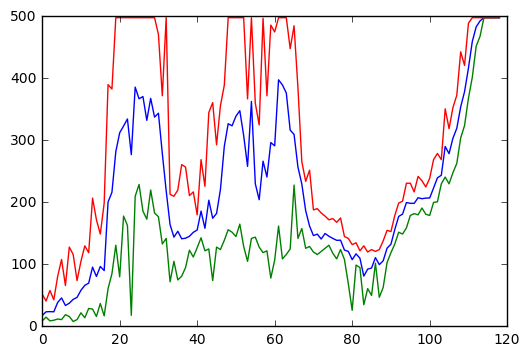

In [143]:
plt.plot(results)
plt.plot(minimums)
plt.plot(maximums)
plt.show()

In [144]:
%%time
_, _, _, result = play_n_games(agent, n=100)
print(np.mean(result))

498.0
CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.4 s
